In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d



class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(channels, channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels // reduction_ratio, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        self.conv1 = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, spatial_kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel_size)

    def forward(self, x):
        x = self.channel_attention(x) * x
        x = self.spatial_attention(x) * x
        return x
class Conv_block(nn.Module):
    def __init__(self, in_channels,out_channels, use_1x1conv=False,stride=1,padding = 1):
        super(Conv_block, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)
        self.ibn1 = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        x = self.conv1(x)
        x = self.ibn1(x)
        x = F.relu(x)
        return x
class ca2_Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(ca2_Residual, self).__init__()

        self.Conv_block1 = Conv_block(in_channels=in_channels, out_channels=out_channels, stride=1,padding=1)
        self.Conv_block2 = Conv_block(in_channels=out_channels, out_channels=out_channels, stride=1,padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1,padding=1)
        self.ibn_3 = nn.BatchNorm1d(out_channels)

        self.conv1_1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
        self.cbam = CBAM(in_channels=out_channels)
        
    def forward(self, x):
        y = self.Conv_block1(x)
        y = self.Conv_block2(y)
        y = self.ibn_3(self.conv1d_3(y))
        y = self.cbam(y)
        x = self.conv1_1(x)
        y =y+x
        end = F.relu(y)
        return end 
class ca2_resnet(nn.Module):
    def __init__(self):
        super(ca2_resnet, self).__init__()
        self.conv1 = Conv_block(in_channels=3, out_channels=8, stride=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3,stride=1)

        self.caResnet1 = ca2_Residual(in_channels=8, out_channels=16, stride=1)
        self.caResnet2 = ca2_Residual(in_channels=16, out_channels=32, stride=1)
        self.caResnet3 = ca2_Residual(in_channels=32, out_channels=32, stride=1)
        self.caResnet4 = ca2_Residual(in_channels=32, out_channels=32, stride=1)

        self.Fl = nn.Flatten()
        self.mlp1 = nn.Sequential(
            nn.Linear(32*98, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 1),
            #nn.Softmax(dim=1)
            nn.Sigmoid()


        )
        self.mlp2 = nn.Sequential(
            nn.Linear(32*98, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256,2),

        )
        self.mlp3 = nn.Sequential(
            nn.Linear(32*98, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256,2),

        )
        
    def forward(self, x):
  
        x = self.conv1(x)#
        x = self.maxpool1(x)
        x = self.caResnet1(x)
        x = self.caResnet2(x)
        x = self.caResnet3(x)
        x = self.caResnet4(x)
        x = self.Fl(x)
        x1 = self.mlp1(x)
        x2 = self.mlp2(x)
        x3 = self.mlp3(x)


        return x1,x2,x3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = ca2_resnet()
net.load_state_dict(torch.load("net_cbam.pth"),strict=False)
net.to(device)
pass

In [6]:
def fill_nan(array):
    overall_mean = np.nanmean(array)
    nan_indices = np.where(np.isnan(array))[0]
    for i in nan_indices:
        start_index = max(0, i - 2)
        end_index = min(len(array), i + 3)
        valid_values = array[start_index:end_index]
        valid_values = valid_values[~np.isnan(valid_values)]
        if len(valid_values) > 0:
            array[i] = np.mean(valid_values)
        else:
            array[i] = overall_mean
    return array
def get3900_4000(spec,zabs):
    wave,flux,err,co=spec
    #ivar=0
    # cond = (err > 0.)
    # wave = wave[cond]
    # flux = flux[cond]
    # err  = err[cond]
    # co   = co[cond]

    cut_range=(wave>=3890*(1+zabs))&(wave<=4001*(1+zabs))
    cutwave=wave[cut_range]
    cutflux=flux[cut_range]
    cuterr=err[cut_range]
    cutco=co[cut_range]

    return (cutwave,cutflux,cuterr,cutco)
def polynomial(x, a0, a1, a2, a3, a4, a5, a6, a7):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4 + a5*x**5 + a6*x**6 + a7*x**7
def read_dr7_0111(fitsname,zabs,zem,co_ori=False,cut=False,poly=False,del2sig=False):
    pass
def read_dr9_0111(fitsname,zabs,zem,co_ori=False,cut=False,poly=False,del2sig=False):
    pass
def read_dr12_0111(fitsname,zabs,zem,co_ori=False,cut=False,poly=False,del2sig=False,and_mask=False):
    pass

SDSS name: J121026.01+651625.2
zabs: 1.019238591 
 zem: 1.671733975 


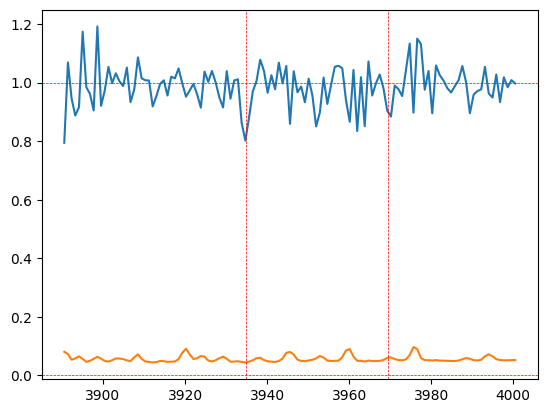

model now class: 0.999
model now ew: [0.43 0.25]
model now fwhm: [2.09 2.12]


In [7]:


fitsname = 'spSpec-52317-0599-462.fit'
zabs = 1.019238591
zem = 1.671733975
print("SDSS name:","J121026.01+651625.2")
print("zabs:",zabs,"\n","zem:",zem,"")

# if fitss.loc[i]['fitsname'].startswith('spec'):
#     path = 'dr12_mg/'+fitsname  
#     spec = read_dr12_0111(path,zabs,zem,co_ori=False,cut=False,poly=False,del2sig=False)
# else:
#     path = "dr7_mg/"+fitsname 
#     spec = read_dr7_0111(path,zabs,zem,co_ori=False,cut=False,poly=False,del2sig=False)
# wave, flux ,err ,co = spec  #range 3900-4000

df = pd.read_csv("spSpec-52317-0599-462.csv")
wave = df['wave'].values
flux = df['flux'].values
err = df['err'].values
co = df['co'].values

    
data = {'wave': wave, 'flux': flux, 'err': err, 'co': co}
df = pd.DataFrame(data)
wave = wave/(1+zabs)
flux = flux/co
err = err/co

plt.figure()
plt.plot(wave,flux)
plt.plot(wave,err)
plt.axvline(3934.77, c="r", ls="--", linewidth=0.5)
plt.axvline(3969.59, c="r", ls="--", linewidth=0.5)
plt.axhline(0, c="r", ls="--", linewidth=0.5)
plt.axhline(1, c="r", ls="--", linewidth=0.5)
plt.show()

# 
min_wave = 3900
max_wave = 4000
step = 1

# 
new_wave = np.concatenate((np.arange(min_wave, wave[0], step), wave, np.arange(wave[-1]+step, max_wave+step, step)))
new_flux = np.concatenate((np.ones(len(np.arange(min_wave, wave[0], step))), flux, np.ones(len(np.arange(wave[-1]+step, max_wave+step, step)))))
average_err = np.mean(err)  
new_err = np.concatenate((np.full(len(np.arange(min_wave, wave[0], step)), average_err), err, np.full(len(np.arange(wave[-1]+step, max_wave+step, step)), average_err)))

# 
flux, err, wave = new_flux, new_err, new_wave

# 
flux_1 = np.clip(flux, None, 1)

# 
f = interp1d(wave, flux_1, kind='cubic')
f_flux_ori = interp1d(wave, flux, kind='cubic')
f_err_ori = interp1d(wave, err, kind='cubic')

inter_wave = np.linspace(3900, 4000, 100)
inter_flux = f(inter_wave)
flux_ori = f_flux_ori(inter_wave)
err_ori = f_err_ori(inter_wave)

# 
err_ori = np.nan_to_num(err_ori, nan=np.nanmean(err_ori))
flux_ori = np.nan_to_num(flux_ori, nan=np.nanmean(flux_ori))
inter_flux = np.nan_to_num(inter_flux, nan=np.nanmean(inter_flux))

flux_ori = np.clip(flux_ori, 0, 2, out=flux_ori)
inter_flux = np.clip(inter_flux, 0, 2, out=inter_flux)

input_x = np.array([inter_flux,flux_ori,err_ori]).reshape(-1, 3, 100)
input_x=torch.from_numpy(input_x.astype(np.float32)).to(torch.float32)
input_x = input_x.to(device)
net.eval()
with torch.no_grad():
        outputs1,outputs2,outputs3 = net(input_x)
print("model now class:", round(outputs1.item(), 3))
print("model now ew:", np.round(outputs2[0].cpu().numpy(), 2))
print("model now fwhm:", np.round(outputs3[0].cpu().numpy(), 2))
sig1_network = outputs3[0][0].item()/(2 * np.sqrt(2 * np.log(2)) )*(1+zabs)
sig2_network = outputs3[0][1].item()/(2 * np.sqrt(2 * np.log(2)) )*(1+zabs)
# sig1_network = fitss.loc[i,"pre_fwhm1"]/(2 * np.sqrt(2 * np.log(2)) )*(1+zabs)
# sig2_network = fitss.loc[i,"pre_fwhm2"]/(2 * np.sqrt(2 * np.log(2)) )*(1+zabs)